# TA session 10

## Partial equailibrium and aggregation of Aiyagari(1994, QJE)


In [15]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(10,6)

In [16]:
class Partial_Aiyagari:
    """
    Partial equilibrium of Aiyagari model with Monte Carlo simulation aggregating mathod
    """
    def __init__(self,
                 Z,         # labor productivity space
                 Π,        # transition matirx for Z
                 β=0.96,   # time discount factor
                 r=0.03,    # interest rate
                 a_lower = 0, # borrowing constraint
                 a_upper = 20, # upper bound
                 N = 100):       # The number of grid points
        self.Z, self.Π, self.β, self.r, self.a_lower, self.a_upper, self.N = Z, Π, β, r, a_lower, a_upper, N
        self.A_grid = np.linspace(a_lower, a_upper, N)
    
    def U_vector(self, c):
        """
        Utility function for vector
        """
        N=len(c)
        U=np.zeros_like(c)
        for i in range(N):
            U[i]=np.log(c[i]) if c[i] > 0 else -1e10
        return U
    
    def T_operator(self, v):
        """
        V_{n+1} = T ( V_ n)
        Bellman equation operator
        """
        Z, Π, A_grid, r, N, β = self.Z, self.Π, self.A_grid, self.r, self.N, self.β
        U = self.U_vector
        S = len(Z)  # labor productivity space dimension
        v_next = np.zeros((N, S))
        policy = np.zeros((N, S))
        
        for j, z in enumerate(Z):
            for i, a in enumerate(A_grid):
                c_vector = z+(1+r)*a - A_grid
                EV_vector = v @ Π[j,:].T
                RHS_vector =U(c_vector) + β* EV_vector
                v_next[i,j] = np.max(RHS_vector)
                policy[i,j] = A_grid[np.argmax(RHS_vector)]
        
        return v_next, policy
    
    def Solve_model(self, max_iter=1000, tolerance=1e-5, verbose=True):
        """
        Solving the HH's problem
        """
        Z, Π, A_grid, r, N = self.Z, self.Π, self.A_grid, self.r, self.N
        S = len(Z)
        
        # step 1) Guess initial value function
        V_0 = np.zeros((N, S))
        v_old = V_0
        
        # step 2) Given V_n, caculate V_n+1 until convergence
        iteration = 0
        error = 1
        while iteration < max_iter and error > tolerance:
            v_next, policy = self.T_operator(v_old)
            error = np.max(np.abs(v_old-v_next))
            iteration += 1
            v_old = v_next # update
        
        if verbose==True and error<tolerance:
            print(f"반복횟수 {iteration}회에서 오차{error}으로 수렴하였습니다!") 
        elif verbose==True and error>tolerance:
            print(f"최대 반복횟수를 초과하여 수렴에 실패하였습니다!")
        
        return v_old, policy 

### Example:  

$ Z= [0.1, 1]$

$\Pi=\begin{bmatrix} 0.9 & 0.1 \\ 0.1 & 0.9\end{bmatrix} $

In [17]:
Z1=np.array([0.1, 1])
Π1=np.array([[0.9, 0.1],[0.1, 0.9]])
model1=Partial_Aiyagari(Z=Z1, Π=Π1)
value, policy = model1.Solve_model()

반복횟수 275회에서 오차9.799123475318083e-06으로 수렴하였습니다!


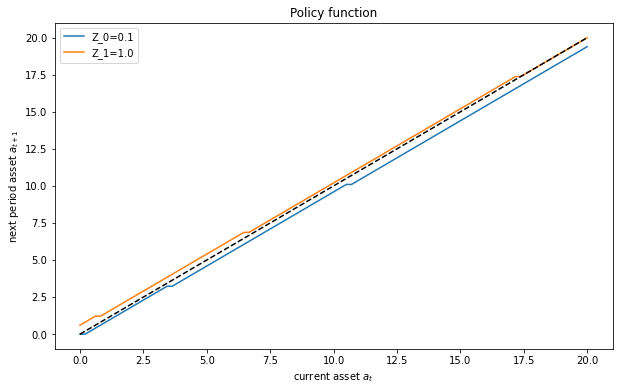

In [18]:
# graph
A_grid=model1.A_grid
plt.plot(A_grid, policy[:,0], label='Z_0=0.1')
plt.plot(A_grid, policy[:,1], label='Z_1=1.0')
plt.plot(A_grid, A_grid, ls='--', c='k')
plt.title('Policy function')
plt.xlabel('current asset $a_t$')
plt.ylabel('next period asset $a_{t+1}$')
plt.legend()
plt.show()

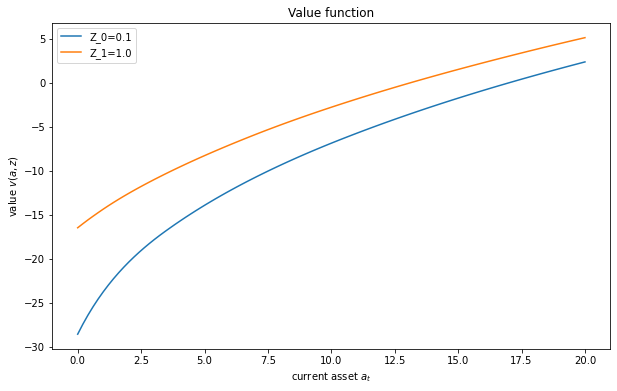

In [19]:
plt.plot(A_grid, value[:,0], label='Z_0=0.1')
plt.plot(A_grid, value[:,1], label='Z_1=1.0')
plt.xlabel('current asset $a_t$')
plt.ylabel('value $v(a,z)$')
plt.title('Value function')
plt.legend()
plt.show()

### Monte Carlo Simulation

The number of HHs: 1000

Total period: 3000

Burn-in: 1000 (delete the initial period for cacluation the momentum of the stationary distribution)

In [107]:
class MC_simulation:
    """
    Aggregation method; Monte Carlo Simulation
    """
    def __init__(self, Z, Π, policy, A_grid, seednum=1275): # seed    
        self.Z, self.Π, self.A_grid = Z, Π, A_grid
        N=len(A_grid)
        S=len(Z)
        policy_idx=np.zeros((N,S))
        for s in range(S):
            for i in range(N):
                policy_idx[i,s] = (np.abs(policy[i,s] - A_grid)).argmin()
        self.policy_idx=policy_idx
        np.random.seed=seednum
    
    def Z_next(self, z):
        """
        Given "z index" sequnce,
        calculate transtion Z_t(index) -> Z_t+1(index)
        """
        Z, Π = self.Z, self.Π
        CumΠ = np.cumsum(Π, axis=1)
        N=len(z)
        ϵ=np.random.rand(N)
        z_next=np.zeros_like(z)
        for i in range(N):
            idx=(np.abs(ϵ[i] - CumΠ[z[i],:])).argmin()
            dis =CumΠ[z[i],idx]-ϵ[i]
            z_next[i]=idx if dis>=0 else idx+1
        return z_next
    
    def A_next(self, a, z):
        """
        Given "a index, z index" sequnce,
        calculate transtion a_t -> a_t+1
        """
        policy_idx, A_grid = self.policy_idx, self.A_grid
        a_next = [int(policy_idx[a[i], z[i]]) for i in range(len(a))]
        return a_next
    
    def simulation(self, T=3000, N=1000, burn_in=1000):
        Z, A_grid = self.Z, self.A_grid
        a_ini_idx=np.random.randint(20, size=1000)
        z_ini_idx=np.random.randint(2, size=1000)
        a_ts = np.zeros((T,N))
        z_ts = np.zeros((T,N))
        a_ts[0,:]=A_grid[a_ini_idx]
        z_ts[0,:]=Z[z_ini_idx]
        
        a_old=a_ini_idx
        z_old=z_ini_idx
        for t in range(T-1):
            a_next_idx = self.A_next(a_old, z_old)
            z_next_idx = self.Z_next(z_old)
            a_ts[t+1,:]=A_grid[a_next_idx]
            z_ts[t+1,:]=Z[z_next_idx]
            a_old = a_next_idx
            z_old = z_next_idx
            
        # Aggregation
        E_a = np.mean(a_ts[T-burn_in:,:])
        E_z = np.mean(z_ts[T-burn_in:,:])
        
            
        return a_ts, z_ts, E_a, E_z      

In [108]:
sim=MC_simulation(Z=Z1, Π=Π1, policy=policy, A_grid=model1.A_grid)

In [114]:
a_ts, z_ts, E_a, E_z =sim.simulation()

In [113]:
# Aggregate asset, and mean labor productivity
print(f"Aggregate asset:{E_a}\nAverage Labor productivity: {E_z}")

Aggregate asset:5.7664585858585875
Average Labor productivity: 0.5528214999999997


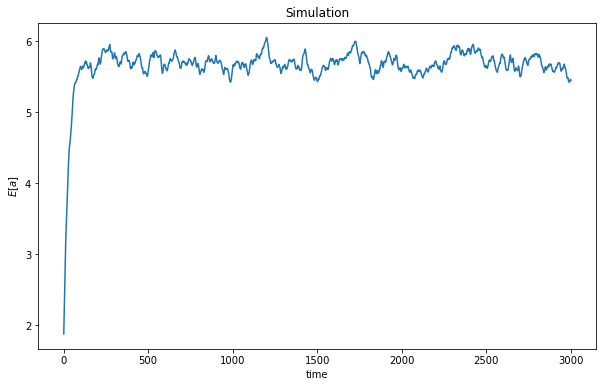

In [111]:
# graph
time=np.linspace(1,3000,3000)
E_a_series=np.mean(a_ts, axis=1)

plt.plot(time, E_a_series)
plt.xlabel('time')
plt.ylabel('$E[a]$')
plt.title('Simulation')
plt.show()